In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import open3d as o3d
import numpy as np
import copy
from typing import Tuple
from tqdm.auto import tqdm

In [21]:
print(o3d.__version__)

0.18.0


In [5]:
MODEL_NAME = "PARAF1_SfM_10Jan24"
MODEL_PATH = f"./data/{MODEL_NAME}.ply"

In [16]:
point_cloud = o3d.io.read_point_cloud(MODEL_PATH)

In [7]:
# center = point_cloud.get_center()  #run this line if you want the center to be the geometric center of the model
center = [0.115773, -0.109477, 0.173592]

center_sphere = o3d.geometry.TriangleMesh.create_sphere(
    radius=0.01, create_uv_map=True
).paint_uniform_color([0, 1, 0])
center_sphere.translate(center)

TriangleMesh with 762 points and 1520 triangles.

In [8]:
def get_dimensions(point_cloud: o3d.geometry.PointCloud) -> Tuple[int, int, int]:
    """returns (width, length, height) of the  3d model"""
    # use the axis aligned bounding box to calculate width, len and height.
    bounding_box = point_cloud.get_axis_aligned_bounding_box()
    bb_pts = np.asarray(bounding_box.get_box_points())
    b_x = list(set(p[0] for p in bb_pts))
    b_y = list(set(p[1] for p in bb_pts))
    b_z = list(set(p[2] for p in bb_pts))

    # calculate width, length, height to set 3d plot's aspect ratio.
    w = abs(b_x[0] - b_x[1])
    l = abs(b_y[0] - b_y[1])
    h = abs(b_z[0] - b_z[1])

    return (w, l, h)

# Extracting horizontal profiles


In [9]:
def get_point_theta(x, y, hyp=1, theta_rad=100):
    """given a point, this function calulates the point at an angle `theta`(in radians) and a distance `hyp` away from the point.

    In a sense, they are opposite ends of the hypotenuse of a right angled triangle with an angle `theta`."""
    x_n = round((x + hyp * np.cos(np.radians(theta_rad))), ndigits=2)
    y_n = round((y + hyp * np.sin(np.radians(theta_rad))), ndigits=2)
    return (x_n, y_n)

In [10]:
w, l, h = get_dimensions(point_cloud)
# xc,yc,zc = point_cloud.get_center()
# xc,yc,zc = [-0.067755, -0.390165, 0.185]
xc, yc, zc = [0.115773, -0.109477, 0.173592]


# make slice from which we sample the points

bb = point_cloud.get_axis_aligned_bounding_box()
z_min, z_max = bb.min_bound[-1], bb.max_bound[-1]


# might need to tweak hyp so that it extends full len of the point cloud
x_new, y_new = get_point_theta(xc, yc, hyp=3, theta_rad=np.radians(5))
# hyp controls the length of slice, theta controls the thickness of the slice
# one common error: object is not in the scene: slice box is too small to be seen in the scene
# other one relates to the service port display - kernel crashing, just restart VScode

bb_slice = o3d.geometry.AxisAlignedBoundingBox(
    np.array([xc, yc, z_min]),
    np.array([x_new, y_new, z_max]),
)
bb_slice = o3d.geometry.OrientedBoundingBox.create_from_axis_aligned_bounding_box(
    bb_slice
)
bb_slice.color = (1, 0, 0)

print(bb_slice)
# o3d.visualization.draw([point_cloud, bb, bb_slice])

OrientedBoundingBox: center: (1.61789, -0.104739, 0.141591), extent: 3.00423, 0.009477, 0.846769)


In [17]:
slice_data = []
# angles_degree = np.arange(0,360,10)
angles_degree = [348.239766]
print(f"Extracting profiles for {len(angles_degree)} angles")
for theta in tqdm(np.deg2rad(angles_degree)):
    cloud_copy = copy.deepcopy(point_cloud)
    cloud_copy.rotate(
        cloud_copy.get_rotation_matrix_from_xyz((0, 0, theta)), center=(xc, yc, zc)
    )
    slice = cloud_copy.select_by_index(
        bb_slice.get_point_indices_within_bounding_box(cloud_copy.points)
    )
    pd.DataFrame(np.asarray(slice.points), columns=["x", "y", "z"])
    o3d.visualization.draw([cloud_copy, bb_slice])
print("done")

Extracting profiles for 1 angles


  0%|          | 0/1 [00:00<?, ?it/s]

[error] GLFW error: Cocoa: Failed to find service port for display


done


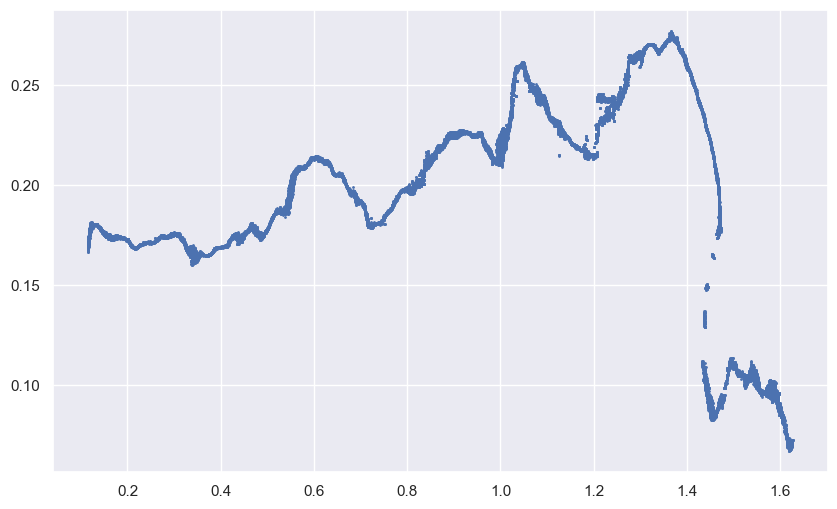

In [23]:
s = slice_data[0]
df = s.points_df.sort_values(by=["x"])
plt.rcParams["figure.figsize"] = (10, 6)  # width, height
f = plt.scatter(df["x"], df["z"], s=1)

In [24]:
df.to_csv("out/PARA-F1_sliceB7.csv", index=False)  # Removes the index column